In [1]:
#import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

from itertools import count
from collections import namedtuple

In [2]:
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
from scipy.spatial.distance import euclidean
import numpy as np
from numpy.random import randint
from itertools import permutations
from random import shuffle
"""
Actions:
    -Draw vertex
    -Measure distance
    -Measure angle
"""
# DEFINE ENVIRONMENT
class GeometryEnvironment():
    def __init__(self):
        self.reset()

    def place_vertex(self, bead_index, vertex_index):
        self.bead_set[bead_index] = vertex_index

    def measure_distance(self, i, j):
        u = self.vertex_set[i]
        v = self.vertex_set[j]
        return euclidean(u, v)
    
    def reset(self, get_complex_reward = False):
        self.get_complex_reward = get_complex_reward
        self.bead_set = np.array([random.randint(0, 3) for i in range(2)])
        self.defining_state = (randint(low=1, high=100), randint(low=1, high=100))
        x = self.defining_state
        self.vertex_set = np.array([(0,0), (x[0],0), (0,x[1]), x])
        self.answer = 0
        self.correct_answer = np.sqrt(self.defining_state[0]**2 + self.defining_state[1]**2)
    
    def basic_reward(self):
        return 1 / (np.abs(self.answer - self.correct_answer)**2)
    
    def complex_reward(self):
        return 1.0 if self.answer == self.correct_answer else 0.0
    
    def step(self, action_index):
        # if distance should be measured
        #print("beads at start of step", self.bead_set)
        if (action_index == 8):
            self.answer = self.measure_distance(self.bead_set[0], self.bead_set[1])
        else:
            vertex_index = action_index % 4
            if (action_index < 5):
                # move first bead
                self.place_vertex(0, vertex_index)
            else:
                self.place_vertex(1, vertex_index)
        done = self.answer == self.correct_answer
        reward = self.complex_reward() if self.get_complex_reward else self.basic_reward()  #1 if done else 0 #1 / (np.abs(self.answer - self.correct_answer)**2)
        #print("beads at end of step", self.bead_set)
        #print("distance: ", self.measure_distance(self.bead_set[0], self.bead_set[1]))
        return reward, done
    
    def get_state(self):
        a = np.array(self.defining_state)
        b = np.array(self.vertex_set[(self.bead_set[0])])
        c = np.array(self.vertex_set[self.bead_set[1]])
        nump = np.concatenate((a, b, c))
        t_state = torch.tensor(nump, dtype=torch.long)
        return t_state.flatten()
    
    def render(self):
        #print("Answer: ", self.answer)
        vertices = np.array([self.vertex_set[(self.bead_set[0])], self.vertex_set[(self.bead_set[1])]])
        #print(vertices)
        x, y = vertices.T
        plt.scatter(x, y)
        plt.show()
    
    def set_state(self, x, y):
        self.defining_state = (int(x), int(y))
        x = self.defining_state
        self.vertex_set = np.array([(0,0), (x[0],0), (0,x[1]), x])
        self.answer = 0
        self.correct_answer = np.sqrt(self.defining_state[0]**2 + self.defining_state[1]**2)



env = GeometryEnvironment()

In [4]:
# REPLAY MEMORY DEFINITION
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

Problems:

-Need to provide float args to vertex position (x and y)

-Need to provide index argument to vertex position

-Need to provide index arguments to distance measurement



In [5]:
# DEFINE THE NETWORK

class DQN(nn.Module):
    def __init__(self, outputs):
        super(DQN, self).__init__()

        self.fc1 = nn.Linear(6, 50)  # 6*6 from image dimension
        self.fc2 = nn.Linear(50, 30)
        self.head = nn.Linear(30, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization
    # Returns a distribution over the possible actions tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = x.float()
        #print(x.shape)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.head(x.view(-1, 30)) # self.head(x.view(x.size(0), -1))

"""
batch_size = 5
nb_classes = 2
in_features = 10

model = nn.Linear(in_features, nb_classes)
criterion = nn.CrossEntropyLoss()
"""

'\nbatch_size = 5\nnb_classes = 2\nin_features = 10\n\nmodel = nn.Linear(in_features, nb_classes)\ncriterion = nn.CrossEntropyLoss()\n'

In [6]:
# DEFINE TRANSITION OPERATIONS
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

# Get number of actions from gym action space
n_actions = 9

policy_net = DQN(n_actions).to(device)
target_net = DQN(n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

# convert to double?
policy_net = DQN(n_actions).float()
target_net = DQN(n_actions).float()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            """
            best_action = policy_net(state)
            best_action = best_action.max(1)
            best_action = best_action[1]
            best_action.view(1, 1)
            """
            return  policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations():
    """
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())
    """



In [7]:
# TRAINING FUNCTION
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))
    #print(batch)

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_batch = state_batch.view(BATCH_SIZE, 6)
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    non_final_next_states = non_final_next_states.view(non_final_next_states.shape[0] // 6, 6)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    state_action_values = state_action_values.double()
    expected_state_action_values = expected_state_action_values.double()
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss = loss.double()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

Episode:  0
Episode:  1
Episode:  2
Episode:  3
Episode:  4
Episode:  5
Episode:  6
Episode:  7
Episode:  8
Episode:  9
Episode:  10
Episode:  11
Episode:  12
Episode:  13
Episode:  14
Episode:  15
Episode:  16
Episode:  17
Episode:  18
Episode:  19
Episode:  20
Episode:  21
Episode:  22
Episode:  23
Episode:  24
Episode:  25
Episode:  26
Episode:  27
Episode:  28
Episode:  29
Episode:  30
Episode:  31
Episode:  32
Episode:  33
Episode:  34
Episode:  35
Episode:  36
Episode:  37
Episode:  38
Episode:  39
Episode:  40
Episode:  41
Episode:  42
Episode:  43
Episode:  44
Episode:  45
Episode:  46
Episode:  47
Episode:  48
Episode:  49
Complete


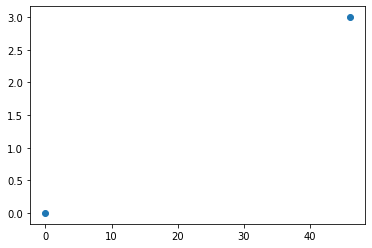

In [8]:
# TRAINING LOOP
num_episodes = 50
for i_episode in range(num_episodes):
    # Initialize the environment and state
    print("Episode: ", i_episode)
    env.reset()
    state = env.get_state()
    for t in count():
        #print(t)
        #print(state)
        # Select and perform an action
        action = select_action(state)
        reward, done = env.step(action.item())
        reward = torch.tensor([reward], device=device)

        # Observe new state
        if not done:
            next_state = env.get_state()
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        optimize_model()
        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')
env.render()
#env.close()
plt.ioff()
plt.show()

In [22]:
test_states = []
test_actions = []

env.reset()
env.set_state(100000, 5)
state = env.get_state()
for t in count():
    print(t)
    #print(state)
    # Select and perform an action
    action = select_action(state)
    reward, done = env.step(action.item())
    reward = torch.tensor([reward], device=device)

    test_states.append(state)
    test_actions.append(action)

    # Observe new state
    if not done:
        next_state = env.get_state()
    else:
        next_state = None


    # Move to the next state
    state = next_state

    if done:
        episode_durations.append(t + 1)
        plot_durations()
        break

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123


In [23]:
import matplotlib.animation as animation
from IPython.display import HTML

measurements = np.array(test_actions) == 8
#=========================================
# Animate Images

fig = plt.figure(figsize=(10, 10))
ims = []
for i in range(len(test_states)):
    x = np.array(test_states[i])[2:5:2]
    y = np.array(test_states[i])[3:6:2]
    if (measurements[i]):
        ims.append([plt.scatter(x, y, animated=True)])
        im, = plt.plot(x, y, 'ro-', animated=True)
    else:
        im = plt.scatter(x, y, animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=300, blit=True, repeat_delay=1000)
plt.close()

# Show the animation
HTML(ani.to_jshtml())